In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import cm
import mpl_toolkits.mplot3d.axes3d
from scipy.interpolate import CubicSpline

In [2]:
K=np.array([[7.70886218e+02, 0.00000000e+00, 4.13139293e+02],
   [0.00000000e+00, 7.370886218e+02, 3.11105542e+02],
   [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
Cx = K[0,2]
Cy = K[1,2]
Fx = K[0,0]
Fy = K[1,1]
F = 0.5*(Fx+Fy)
Rp = 0.06 #El diametro de la pelota
N = 2000
N = N + 1

In [3]:
#Genera Datos de Movimiento.
Pini = np.array([0.15, 0.2, 0.6])

#Incremento de la rotacion
theta = 1 * np.pi/180

#Matrix de Rotacion
Rt = np.array([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta), np.cos(theta), 0],[0, 0, 1]])


#Secuencia de Posiciones
Xgt = np.zeros((6,N))

#radio en pixeles de la pelota
r =  np.zeros ((1, N))
dr = np.zeros ((1, N))


#tiempo entre mediciones (segundos)
dt = 1 / 30

#Calculamos la secuencia de posiciones.
Pos = Pini;

inc = 4.8 / (N - 1)

for i in range(N//2):
    Xgt[0:3, i] = Pos;
    r[0,i] = F * Rp / Pos[2];
    Pos = np.dot(Rt, Pos) + [0, 0, inc]

for i in range(N//2, N):
    Xgt[0:3, i] = Pos;
    r[0,i] = F * Rp / Pos[2];
    Pos = np.dot(Rt, Pos) - [0, 0, inc]
    

T = np.linspace(0,N,N)*dt

In [4]:
#Proyectamos y normalizamos coordenadas 3D al plano de la imagen.
p = np.dot(K, Xgt[0:3,:])
r = np.zeros((1,N))
for i in range(len(p[0])):
    p[:,i] = p[:, i]/p[2,i]
    r[0,i] = F * Rp / Xgt[2,i]
dp = np.diff(p[0:2,:])
dr = np.diff(r)
pxMin = np.min(p[0,:])
pxMax = np.max(p[0,:])
pyMin = np.min(p[1,:])
pyMax = np.max(p[1,:])

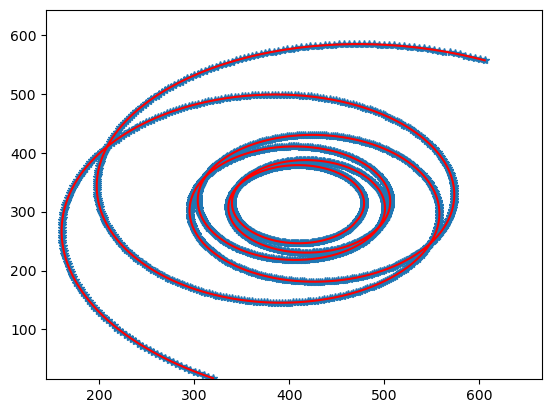

In [5]:
fig1=plt.figure()

ax1 = fig1.add_subplot(111, autoscale_on=False, xlim=((1-0.1)*pxMin,(1+0.1)*pxMax), ylim=((1-0.1)*pyMin,(1+0.1)*pyMax))
plt.plot(p[0,:],p[1,:],'*',p[0,:],p[1,:],'r')

In [6]:
#Llenamos el vector de medicion.
z =np.zeros((6,N))
z[0:3,0]=[p[0,0],p[1,0],r[0,0]]
z[:,1:N]=np.vstack([p[0,1:N],p[1,1:N],r[0,1:N], dp[0,:]/dt, dp[1,:]/dt, dr[0,:]/dt])

In [7]:
#definimos en ruido de medicion.
varPosX = 1.
varPosY = 1.
varR = 1. * 10e-2
varVelX = 1.5 * 10e-4
varVelY = 1.5 * 10e-4
varVelR = 1.5 * 10e-5

factNR = 1.

noiseX = rnd.normal(0,np.sqrt(varPosX),(1,N))
noiseY = rnd.normal(0,np.sqrt(varPosY),(1,N))
noiseR = rnd.normal(0,np.sqrt(varR),(1,N))
noiseVX = rnd.normal(0,np.sqrt(varVelX),(1,N))
noiseVY = rnd.normal(0,np.sqrt(varVelY),(1,N))
noiseVR = rnd.normal(0,np.sqrt(varVelR),(1,N))

#Vectores de Medicion (proyeccion de posicion + ruido).
#Esta es la entrada de datos para el filtro de Kalman.
zn = z + factNR * np.vstack([noiseX, noiseY, noiseR, noiseVX, noiseVY, noiseVR])

#Estimamos el ruido de la medicion y lo 'canonizo'.
R =  np.cov(factNR * np.vstack([noiseX/Fx, noiseY/Fy, noiseR/F, noiseVX/Fx, noiseVY/Fy, noiseVR/F]))

#Definimos el ruido del proceso
Q = np.cov(rnd.rand(6,N))*np.diag([0.04, 0.04, 0.04, 0.2, 0.2, 0.2])/200

In [8]:
#Terminamos de definimos el Estado (ground truth)
Xgt[3:6, 0:N-1] = np.vstack([np.diff(Xgt[0,:]), np.diff(Xgt[1,:]), np.diff(Xgt[2,:])]) / dt
Xgt[3:6, N-1] = Xgt[3:6, N-2]

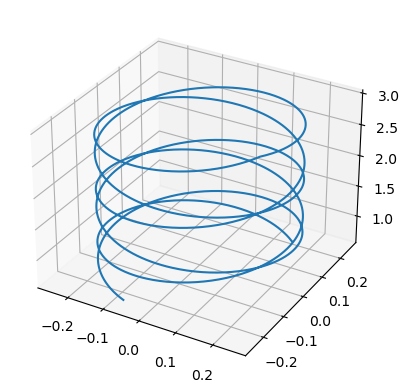

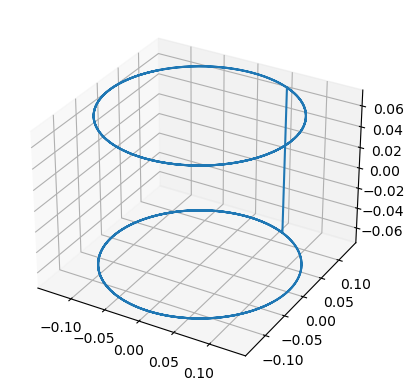

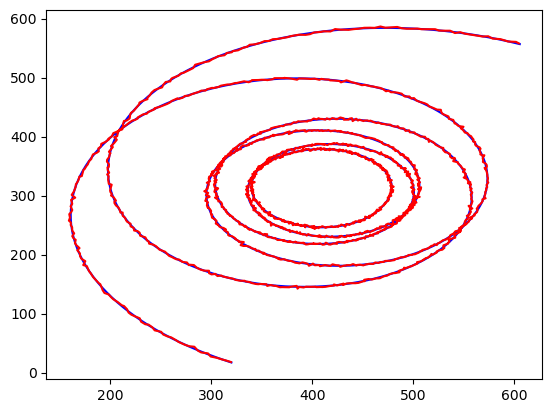

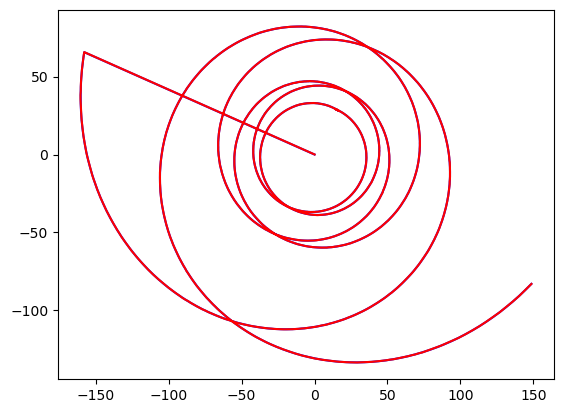

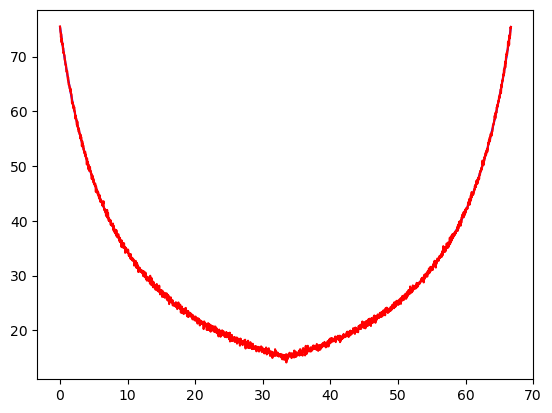

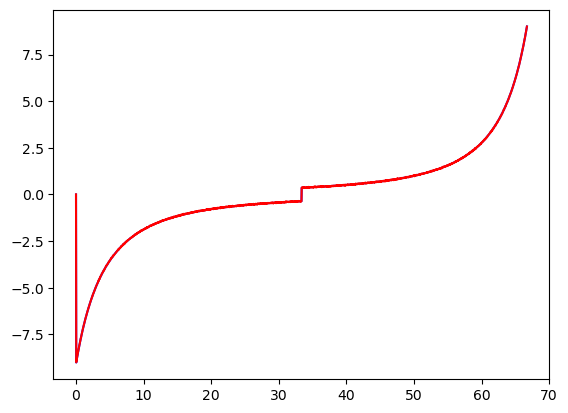

In [9]:
fig2=plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
plt.plot(Xgt[0,:], Xgt[1,:], Xgt[2,:])

fig3=plt.figure()
ax3 = fig3.add_subplot(111, projection='3d')
plt.plot(Xgt[3,:], Xgt[4,:], Xgt[5,:])

fig4=plt.figure()
ax4 = fig4.add_subplot(111)
plt.plot(z[0,:],z[1,:],'b', zn[0,:],zn[1,:],'r')

fig5=plt.figure()
ax5 = fig5.add_subplot(111)
plt.plot(z[3,:],z[4,:],'b', zn[3,:],zn[4,:],'r')

fig6=plt.figure()
ax6 = fig6.add_subplot(111)
plt.plot(T,z[2,:],'b', T,zn[2,:],'r')

fig7=plt.figure()
ax7 = fig7.add_subplot(111)
plt.plot(T,z[5,:],'b', T,zn[5,:],'r')


In [10]:
A = np.eye(6)
A[0,3] = dt
A[1,4] = dt
A[2,5] = dt

In [11]:
x = Xgt[:,0]

xp = np.zeros((6, 1))

zk = np.zeros((6, 1))

Hk = np.zeros((6,6))

Kg = np.zeros((6,6))

#Definimos el Ruido del estado
Pk = 10 * np.eye(6)

#Ruido del estado predicho.
Pkp = np.zeros((6,6))

XE = np.zeros((6,N+1))
ZKS = np.zeros((6,N+1))
ZK = np.zeros((6, 1))


In [12]:
k = 0
N=2000
while k < N:
    
    #Predicción
    xp = np.dot(A,x)
    Pkp = np.dot(A , np.dot(Pk, A.transpose())) + Q
    
    #Obtenemos una medición
    zk = zn[:,k]
    
    if k == 0:
        zk[3:] = 0
        
    #Lo convertimos en coordenadas canonicas.
    zk[0] = (zk[0] - Cx) / Fx
    zk[1] = (zk[1] - Cy) / Fy
    zk[2] = zk[2] / F
    zk[3] = zk[3] / Fx
    zk[4] = zk[4] / Fy
    zk[5] = zk[5] / F
    
    ZK = np.array([xp[0]/xp[2], xp[1]/xp[2], Rp/xp[2], -(-xp[3]+(xp[0]/xp[2])*xp[5])/xp[2],-(-xp[4]+(xp[1]/xp[2])*xp[5])/xp[2], -Rp*xp[5]/(xp[2]*xp[2])])
    ZKS[:,k] = ZK
    
    X = xp[0]
    Y = xp[1]
    Z = xp[2]
    dX = xp[3]
    dY = xp[4]
    dZ = xp[5]
    Z2 = Z * Z
    Z3 = Z2 * Z
    
    Hk = np.array(\
     [[1/Z,      0,      -X/Z2,                   0,   0,    0],\
      [0,      1/Z,      -Y/Z2,                   0,   0,    0],\
      [0,       0,      -Rp/Z2,                   0,   0,    0],\
      [-dZ/Z2,  0,   (X*dZ)/Z3-(dX-(X*dZ)/Z)/Z2, 1/Z,  0,  -X/Z2],\
      [0,    -dZ/Z2, (Y*dZ)/Z3-(dY-(Y*dZ)/Z)/Z2,  0,  1/Z, -Y/Z2],\
      [0,       0,  2*Rp*dZ/Z3 ,                  0,   0,  -Rp/Z2]])
    
    
    #Calculamos la ganancia de Kalman
    Kg = np.dot(Pkp, np.dot(Hk.transpose(), np.linalg.inv(np.dot(Hk, np.dot(Pkp, Hk.transpose())) + R)));
    #Update
    xek = xp + np.dot(Kg, (zk - ZK))
    Pk = np.dot(np.eye(6)-np.dot(Kg, Hk), Pkp)
    
    XE[:,k] = xek
    x = xek
    k = k + 1

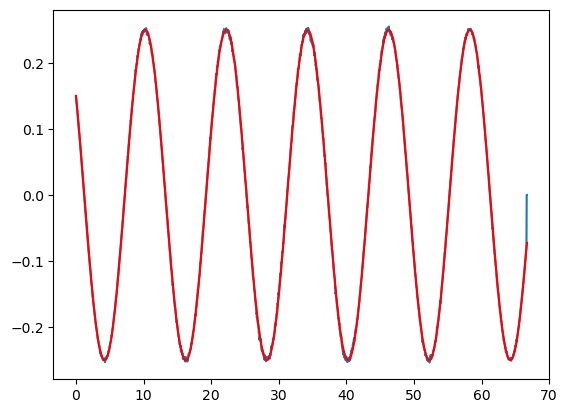

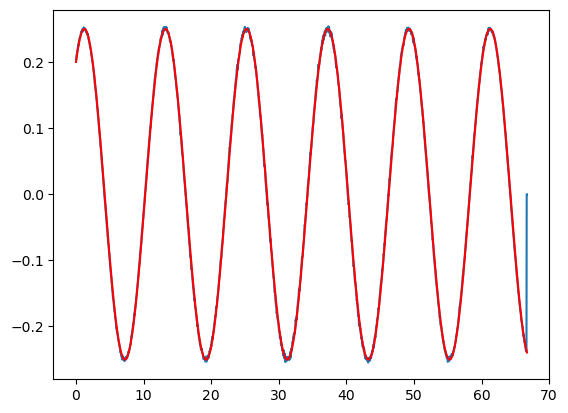

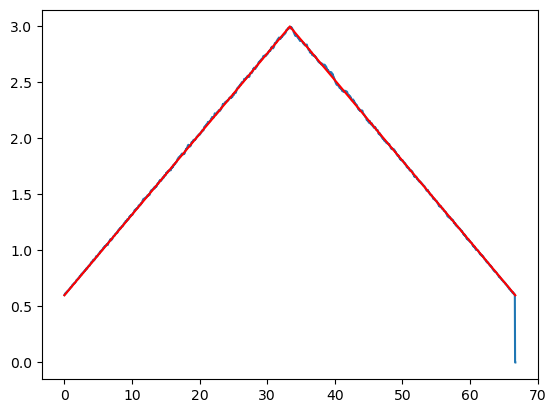

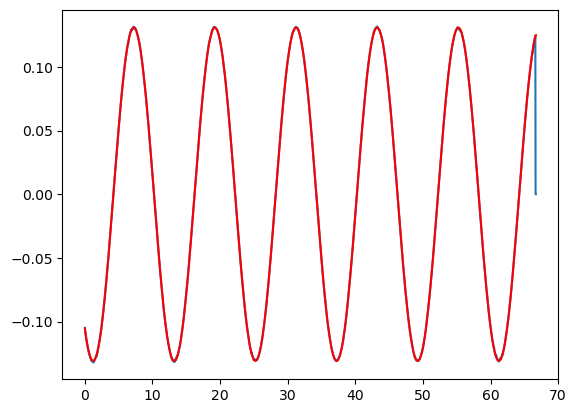

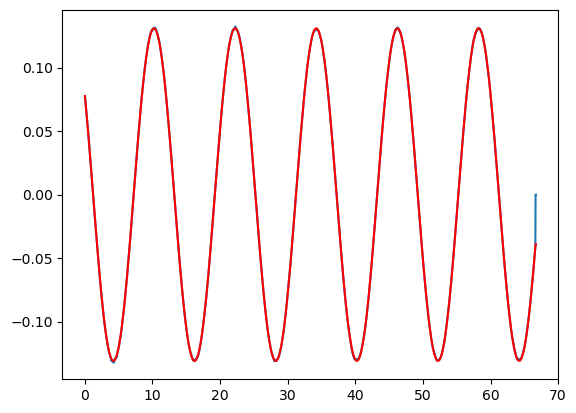

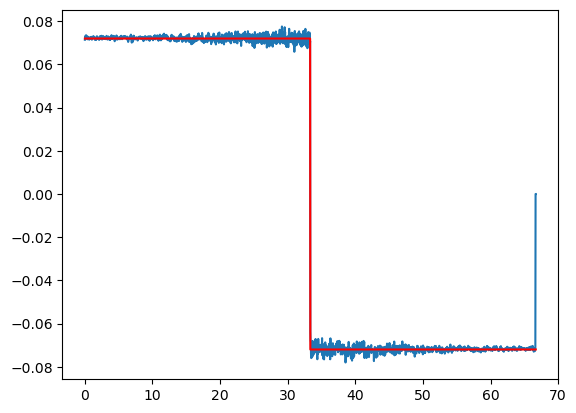

In [13]:
fig8=plt.figure()
ax8 = fig8.add_subplot(111)
plt.plot(T, XE[0,1:],T, Xgt[0,:],'r')

fig9=plt.figure()
ax9 = fig9.add_subplot(111)
plt.plot(T, XE[1,1:],T, Xgt[1,:],'r')

fig10=plt.figure()
ax10 = fig10.add_subplot(111)
plt.plot(T, XE[2,1:],T, Xgt[2,:],'r')

fig11=plt.figure()
ax11 = fig11.add_subplot(111)
plt.plot(T, XE[3,1:],T, Xgt[3,:],'r')

fig12=plt.figure()
ax12 = fig12.add_subplot(111)
plt.plot(T, XE[4,1:],T, Xgt[4,:],'r')

fig13=plt.figure()
ax13 = fig13.add_subplot(111)
plt.plot(T, XE[5,1:],T, Xgt[5,:],'r')

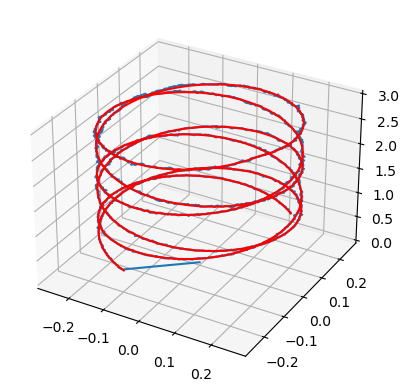

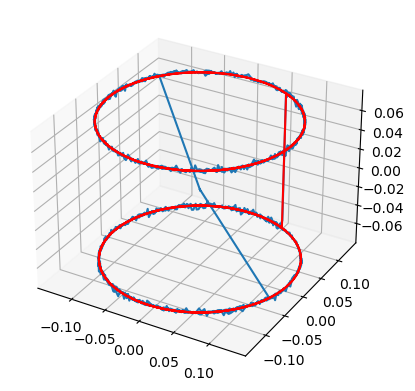

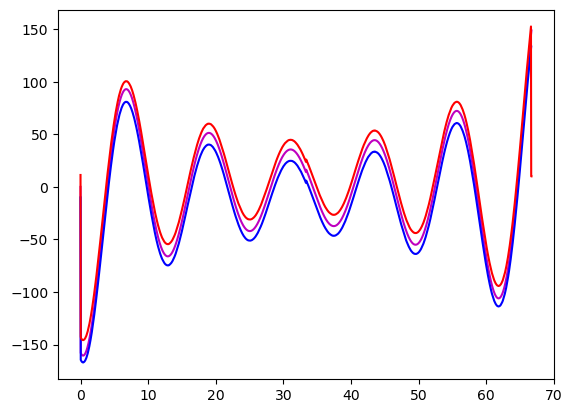

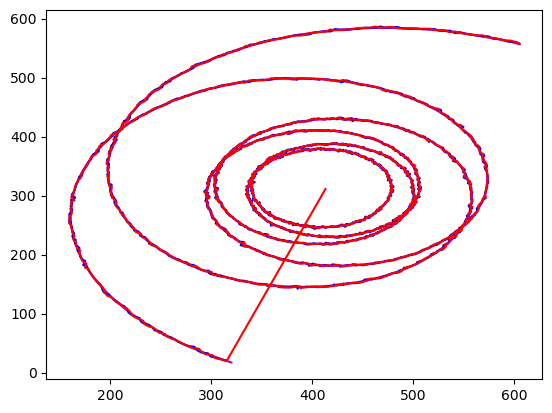

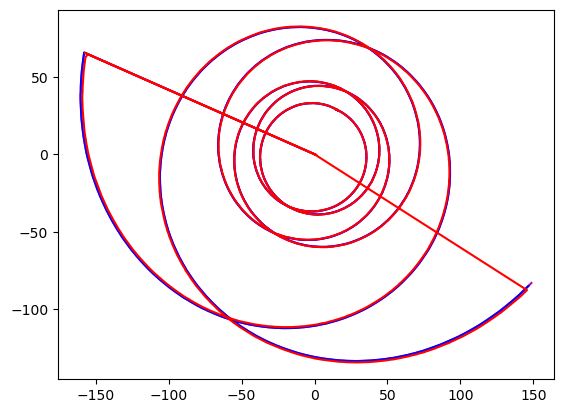

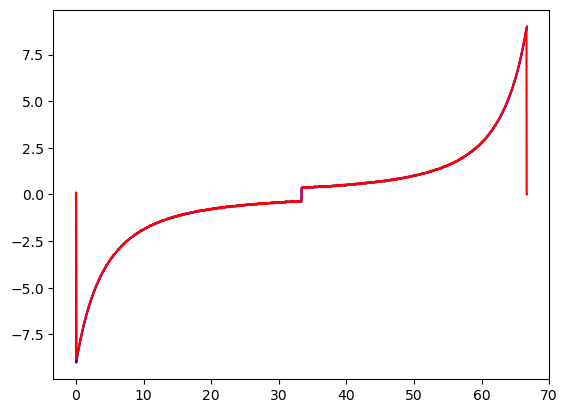

In [14]:
fig14=plt.figure()
ax14 = fig14.add_subplot(111, projection='3d')
plt.plot(XE[0,:], XE[1,:], XE[2,:])
plt.plot(Xgt[0,:], Xgt[1,:], Xgt[2,:],'r')

fig15=plt.figure()
ax15 = fig15.add_subplot(111, projection='3d')
plt.plot(XE[3,:], XE[4,:], XE[5,:])
plt.plot(Xgt[3,:], Xgt[4,:], Xgt[5,:],'r')

fig16=plt.figure()
ax16 = fig16.add_subplot(111)
plt.plot(T, z[3,:], 'm')
plt.plot(T[:-1], -10+F*zn[3,:-1], 'b')
plt.plot(T, 10+F*ZKS[3,1:], 'r')


fig17=plt.figure()
ax17 = fig17.add_subplot(111)
plt.plot(z[0,:], z[1,:], 'm')
plt.plot(zn[0,:-1]*Fx+Cx, zn[1,:-1]*Fy+Cy, 'b')
plt.plot(ZKS[0,:]*Fx+Cx, ZKS[1,:]*Fy+Cy, 'r')

fig18=plt.figure()
ax18 = fig18.add_subplot(111)
plt.plot(z[3,:], z[4,:], 'm')
plt.plot(zn[3,:-1]*Fx, zn[4,:-1]*Fy, 'b')
plt.plot(ZKS[3,:]*Fx, ZKS[4,:]*Fy, 'r')

fig19=plt.figure()
ax19 = fig19.add_subplot(111)
plt.plot(T, z[5,:], 'm')
plt.plot(T[:-1], F*zn[5,:-1], 'b')
plt.plot(T, F*ZKS[5,1:], 'r')
